In [169]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from bcb import sgs
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
import joblib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import  ClassBalance,DiscriminationThreshold
from lime import lime_tabular
from sklearn.base import BaseEstimator, ClassifierMixin
from scikitplot.metrics import plot_roc, plot_precision_recall
import pandas_datareader.data as web
import datetime as dt 
from hurst import compute_Hc, random_walk
import wbdata as wb
from pytrends.request import TrendReq
import seaborn as sns
import talib as tb


In [170]:
#conexão com o servidor
pytrends = TrendReq(hl='en-US', tz=360)

#lista com palavra chave
kw_list = ['bitcoin']

#download google trends
pytrends.build_payload(kw_list, cat=0, timeframe='2014-07-01 2023-08-14', geo='',gprop='' )
teste = pytrends.interest_over_time()

In [171]:
#conexão com o servidor
pytrends = TrendReq(hl='en-US', tz=360)

#lista com palavra chave
kw_list1 = ['bitcoin will decrease']

#download google trends
pytrends.build_payload(kw_list1, cat=0, timeframe='2014-07-01 2023-08-14', geo='',gprop='' )
teste1 = pytrends.interest_over_time()

In [172]:
teste1

,bitcoin will decrease,isPartial
date,,
2014-07-01,18,False
2014-08-01,0,False
2014-09-01,0,False
2014-10-01,0,False
2014-11-01,0,False
...,...,...
2023-04-01,8,False
2023-05-01,18,False
2023-06-01,17,False


In [173]:
ativos = ["BTC-USD"]
df = yf.download(ativos, start="2014-01-01")
index = df.index
dfd = web.DataReader('FF', 'fred', "1995-01-01", "2023-09-14")
dfs = yf.download('^GSPC', start="2005-01-01")
dfcambio = pd.read_csv('Dólar Comercial USD BRL Futuro Dados Históricos.csv')
# index = df.index
# dvix = yf.download('^VIX',start="2000-01-01")

# df["retorno"] = df["Close"].pct_change()
# df["retorno shifted"] = df["Close"].pct_change().shift(-1)
# dfs["retorno"] = dfs["Adj Close"].pct_change()
# df["vix pct"] = dvix["Close"].pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [174]:
# dfcambio = dfcambio.set_index("Data", inplace=False)

In [175]:
for i in range(len(dfcambio)):
    texto = dfcambio["Data"].iloc[i]
    texto = texto.replace('.','-')
    dfcambio["Data"].iloc[i] = texto

In [176]:
dfcambio["Data"] = pd.to_datetime(dfcambio["Data"])

In [177]:
dfcambio["Data"] = dfcambio["Data"].dt.strftime('%Y-%m-%d')
dfcambio["Data"] = pd.to_datetime(dfcambio["Data"])

In [178]:
dfcambio

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2015-03-27,"3.238,16","3.189,50","3.253,00","3.184,00","300,19K","1,27%"
1,2015-03-26,"3.197,60","3.210,00","3.228,00","3.177,00","360,03K","-0,04%"
2,2015-03-25,"3.198,73","3.178,00","3.209,50","3.121,50","360,12K","1,94%"
3,2015-03-24,"3.137,88","3.125,00","3.179,50","3.099,00","418,34K","-1,23%"
4,2015-03-23,"3.177,03","3.224,00","3.232,50","3.138,50","364,98K","-1,90%"
...,...,...,...,...,...,...,...
4995,1995-06-01,"862,23","856,00","862,50","856,00","109,84K","0,37%"
4996,1995-05-01,"859,02","860,00","861,50","858,50","121,45K","-0,55%"
4997,1995-04-01,"863,74","866,00","866,00","863,00","91,39K","-0,12%"
4998,1995-03-01,"864,77","866,00","867,00","863,00","115,16K","0,12%"


In [179]:
dfcambio = dfcambio.sort_values(by='Data')

In [180]:
dfcambio = dfcambio.set_index("Data", inplace=False)

In [181]:
df.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01',
               '2023-12-02', '2023-12-03', '2023-12-04', '2023-12-05',
               '2023-12-06', '2023-12-07'],
              dtype='datetime64[ns]', name='Date', length=3369, freq=None)

In [182]:
df["dolar futuros"] = dfcambio["Abertura"]

In [183]:

df["dolar futuros"] = df["dolar futuros"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["dolar futuros"].iloc[i] != 0):
        valor = df["dolar futuros"].iloc[i]
    elif(df["dolar futuros"].iloc[i] == 0):
        df["dolar futuros"].iloc[i] = valor 

c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [184]:
df =df.dropna()
for i in range(len(df)):
    texto1 = df["dolar futuros"].iloc[i]
    texto1 = texto1.replace('.', '')
    texto1 = texto1.replace(',','.')
    df["dolar futuros"].iloc[i] = texto1



In [185]:
df["juros americano"] = dfd["FF"]
df["juros americano"] = df["juros americano"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["juros americano"].iloc[i] != 0):
        valor = df["juros americano"].iloc[i]
    elif(df["juros americano"].iloc[i] == 0):
        df["juros americano"].iloc[i] = valor 

In [186]:
df["trendbtc"] = teste[kw_list]
df["trendbtc"] = df["trendbtc"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["trendbtc"].iloc[i] != 0):
        valor = df["trendbtc"].iloc[i]
    elif(df["trendbtc"].iloc[i] == 0):
        df["trendbtc"].iloc[i] = valor 

In [187]:
df["trendbtcdc"] = teste1[kw_list1]
df["trendbtcdc"] = df["trendbtcdc"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["trendbtcdc"].iloc[i] != 0):
        valor = df["trendbtcdc"].iloc[i]
    elif(df["trendbtcdc"].iloc[i] == 0):
        df["trendbtcdc"].iloc[i] = valor 

In [188]:
df

,Open,High,Low,Close,Adj Close,Volume,dolar futuros,juros americano,trendbtc,trendbtcdc
Date,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2343.00,0.09,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,2364.00,0.09,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,2372.50,0.09,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,2372.50,0.09,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,2372.50,0.09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-03,39472.207031,40135.605469,39298.164062,39978.390625,39978.390625,15769696322,3113.50,5.33,17.0,11.0
2023-12-04,39978.628906,42371.750000,39978.628906,41980.097656,41980.097656,39856129827,3113.50,5.33,17.0,11.0
2023-12-05,41986.265625,44408.664062,41421.148438,44080.648438,44080.648438,36312154535,3113.50,5.33,17.0,11.0


In [189]:
fast, slow, histogram = tb.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df["fastsignal"] = fast
df["slowsignal"] = slow
df["hist"] = histogram
k, d = tb.STOCHRSI(df["Close"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
k = pd.DataFrame(k)
d = pd.DataFrame(d)
df = df.dropna()

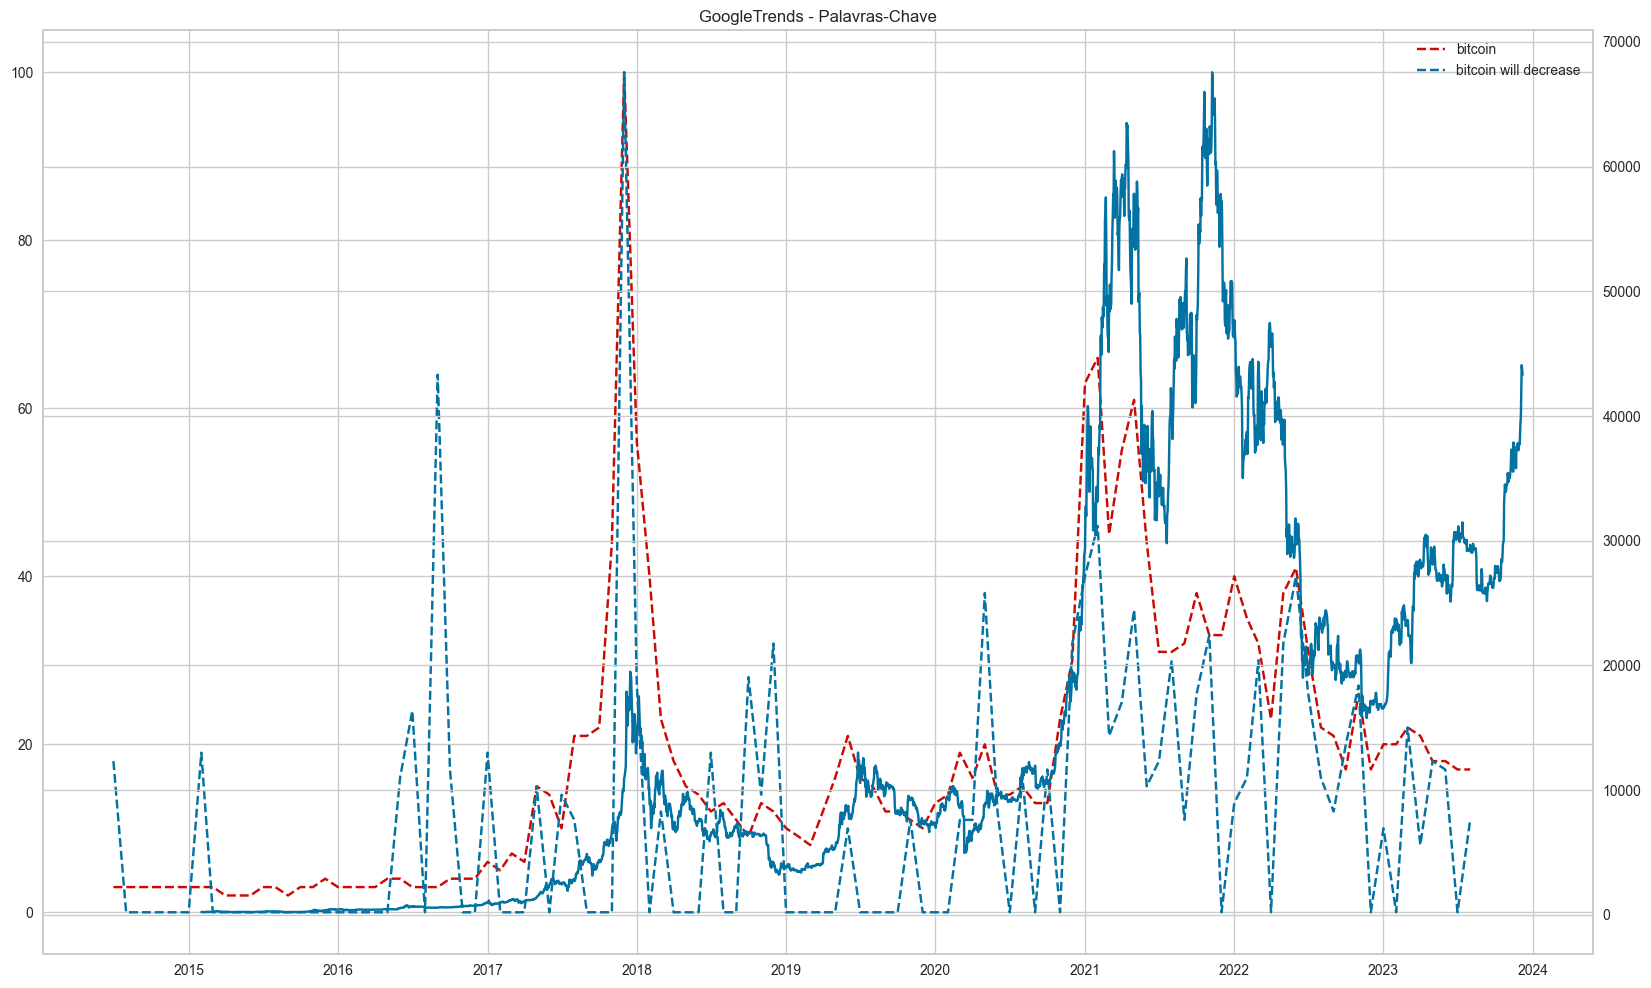

In [190]:
figura = plt.figure(figsize=(20,12))
ax1=plt.subplot(111)
plt.title('GoogleTrends - Palavras-Chave')
#formação da figura
ax1.plot(teste[kw_list], '--r', label="bitcoin")
ax1.plot(teste1[kw_list1], '--b', label="bitcoin will decrease")
ax2=ax1.twinx()
ax2.plot(df["Close"])


ax1.legend()

In [191]:
start_date = dt.datetime(1970, 1, 1)
end_date = dt.datetime.now()
dftesouro10 = web.DataReader('DGS10', 'fred',start_date, end_date)
dftesouro2 = web.DataReader('DGS2', 'fred',start_date, end_date)
pibamericano = web.DataReader('GDP', 'fred',start_date, end_date)
infamericana = web.DataReader('CPIAUCSL', 'fred',start_date, end_date)
fluxocapital = web.DataReader('NETFI', 'fred',start_date, end_date)

In [192]:
df["FDI"] = fluxocapital

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [193]:

df["FDI"] = df["FDI"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["FDI"].iloc[i] != 0):
        valor = df["FDI"].iloc[i]
    elif(df["FDI"].iloc[i] == 0):
        df["FDI"].iloc[i] = valor 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3232 entries, 2015-02-01 to 2023-12-07
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             3232 non-null   float64
 1   High             3232 non-null   float64
 2   Low              3232 non-null   float64
 3   Close            3232 non-null   float64
 4   Adj Close        3232 non-null   float64
 5   Volume           3232 non-null   int64  
 6   dolar futuros    3232 non-null   object 
 7   juros americano  3232 non-null   float64
 8   trendbtc         3232 non-null   float64
 9   trendbtcdc       3232 non-null   float64
 10  fastsignal       3232 non-null   float64
 11  slowsignal       3232 non-null   float64
 12  hist             3232 non-null   float64
 13  FDI              3173 non-null   float64
dtypes: float64(12), int64(1), object(1)
memory usage: 378.8+ KB


In [195]:
dfte = dftesouro10.join(dftesouro2)
dfte = dfte.dropna()
dfte

,DGS10,DGS2
DATE,,
1976-06-01,7.94,7.26
1976-06-02,7.94,7.23
1976-06-03,7.92,7.22
1976-06-04,7.89,7.12
1976-06-07,7.88,7.09
...,...,...
2023-11-29,4.27,4.64
2023-11-30,4.37,4.73
2023-12-01,4.22,4.56


In [196]:
df["CPI"] = infamericana
df["CPI"] = df["CPI"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["CPI"].iloc[i] != 0):
        valor = df["CPI"].iloc[i]
    elif(df["CPI"].iloc[i] == 0):
        df["CPI"].iloc[i] = valor 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

In [197]:
df["pib"] = pibamericano
df["pib"] = df["pib"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["pib"].iloc[i] != 0):
        valor = df["pib"].iloc[i]
    elif(df["pib"].iloc[i] == 0):
        df["pib"].iloc[i] = valor 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [198]:
dfte["ratio"] = dfte["DGS2"]/dfte["DGS10"]

In [199]:
dfte["ratio average"] = dfte["ratio"].rolling(500).mean()
dfte["sinal"] = np.where((dfte["ratio"] < dfte["ratio average"]), 0, 1)


In [200]:
# def get_tsfresh_features(df):
#     # Get statistic features using library TSFRESH 
#     # Thanks to https://www.kaggle.com/code/vbmokin/btc-growth-forecasting-with-advanced-fe-for-ohlc
    
#     df = df.reset_index(drop=False).reset_index(drop=False)
    
#     # Extract features
#     extracted_features = extract_features(df, column_id="Date", column_sort="Date")
    
#     # Drop features with NaN
#     extracted_features_clean = extracted_features.dropna(axis=1, how='all').reset_index(drop=True)
    
#     # Drop features with constants
#     cols_std_zero  = []
#     for col in extracted_features_clean.columns:
#         if extracted_features_clean[col].std()==0:
#             cols_std_zero.append(col)
#     extracted_features_clean = extracted_features_clean.drop(columns = cols_std_zero)

#     # extracted_features_clean['Date'] = df["Date"]   # For the merging
    
#     return extracted_features_clean

In [201]:
# %%time
# # FE with TSFRESH
# extracted_features_clean = get_tsfresh_features(df[['Close']])



In [202]:
# Extracted features by TSFRESH with cleaning
# extracted_features_clean.columns.tolist()

In [203]:
# # Get all features
# df = pd.merge(df, extracted_features_clean, how='left', on=df.index)


In [204]:
df

,Open,High,Low,Close,Adj Close,Volume,dolar futuros,juros americano,trendbtc,trendbtcdc,fastsignal,slowsignal,hist,FDI,CPI,pib
Date,,,,,,,,,,,,,,,,
2015-02-01,216.867004,231.574005,212.014999,226.972000,226.972000,29128500,2698.00,0.12,3.0,19.0,-11.457536,-13.660909,2.203373,NaN,235.342,NaN
2015-02-02,226.490997,242.175003,222.658997,238.229004,238.229004,30612100,2695.00,0.12,3.0,19.0,-10.318072,-12.992342,2.674270,NaN,235.342,NaN
2015-02-03,237.453995,245.957001,224.483002,227.268005,227.268005,40783700,2889.00,0.12,3.0,19.0,-10.182126,-12.430299,2.248173,NaN,235.342,NaN
2015-02-04,227.511002,230.057999,221.113007,226.852997,226.852997,26594300,2889.00,0.09,3.0,19.0,-9.992686,-11.942776,1.950090,NaN,235.342,NaN
2015-02-05,227.664993,239.404999,214.725006,217.110992,217.110992,22516400,2889.00,0.09,3.0,19.0,-10.507528,-11.655726,1.148199,NaN,235.342,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03,39472.207031,40135.605469,39298.164062,39978.390625,39978.390625,15769696322,3113.50,5.33,17.0,11.0,1106.471475,1030.619074,75.852401,-820.286,307.619,27644.463
2023-12-04,39978.628906,42371.750000,39978.628906,41980.097656,41980.097656,39856129827,3113.50,5.33,17.0,11.0,1325.957364,1089.686732,236.270632,-820.286,307.619,27644.463
2023-12-05,41986.265625,44408.664062,41421.148438,44080.648438,44080.648438,36312154535,3113.50,5.33,17.0,11.0,1650.373923,1201.824170,448.549753,-820.286,307.619,27644.463


In [205]:
# df = df.drop(columns='key_0')

In [206]:
# df = df.set_index(index, inplace=False)

In [207]:
df["retorno"] = df["Close"].pct_change()
# df["retorno shifted"] = df["Close"].pct_change().shift(-1)
dfs["retorno"] = dfs["Adj Close"].pct_change()
# df['vix'] = dvix["Close"]
# df['pct vix'] = df['vix'].pct_change()


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [208]:
df = df.dropna()
dfs = dfs.dropna()

In [209]:
s = df['Close'][-500:]

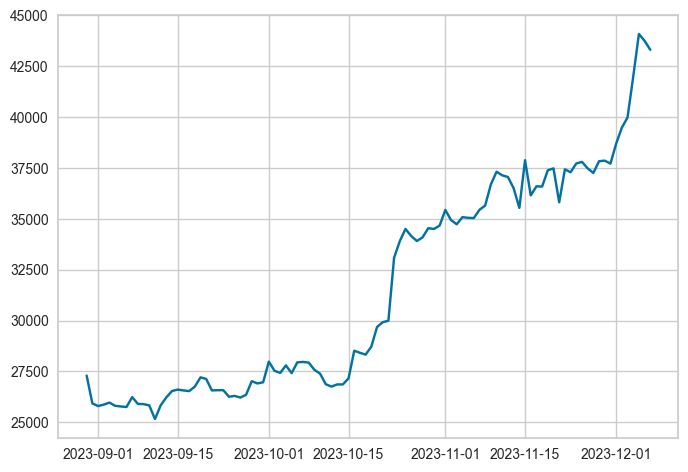

In [210]:
plt.plot(df.index[-100:], df["Close"][-100:])

In [211]:

H, c, val = compute_Hc(s)

In [212]:
print("Hurst exponent = {:.4f}".format(H))

Hurst exponent = 0.5963


In [213]:
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [214]:
cdi = sgs.get({'CDI':12}, start='1970-01-01')
ipca = sgs.get({'IPCA':433}, start='2005-01-01')

In [215]:
df["ipca"] = ipca

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [216]:
df["ipca"] = ipca
df["ipca"] = df["ipca"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["ipca"].iloc[i] != 0):
        valor = df["ipca"].iloc[i]
    elif(df["ipca"].iloc[i] == 0):
        df["ipca"].iloc[i] = valor 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

In [217]:
df["cdi"] = cdi
df["cdi"] = df["cdi"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["cdi"].iloc[i] != 0):
        valor = df["cdi"].iloc[i]
    elif(df["cdi"].iloc[i] == 0):
        df["cdi"].iloc[i] = valor 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
df["cdi"] = cdi/100

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [219]:
df = df.dropna()

In [220]:
vetor = list([])
for i in range(len(df)-1):
    if (i == len(df)):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i+1]  <  df["Adj Close"].iloc[i]):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i+1]  >  df["Adj Close"].iloc[i]): 
        vetor.append(1)
    else:
        vetor.append(0)

In [221]:
df = df.drop(df.index[0])
df['signal'] = pd.array(vetor).shift(-1)
df = df.dropna()


In [222]:
# df = df.drop(columns=['index__sum_values',
#  'index__abs_energy',
#  'index__median',
#  'index__mean',
#  'index__root_mean_square',
#  'index__maximum',
#  'index__absolute_maximum',
#  'index__minimum',
#  'index__benford_correlation',
#  'index__quantile__q_0.1',
#  'index__quantile__q_0.2',
#  'index__quantile__q_0.3',
#  'index__quantile__q_0.4',
#  'index__quantile__q_0.6',
#  'index__quantile__q_0.7',
#  'index__quantile__q_0.8',
#  'index__quantile__q_0.9',
#  'index__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
#  'index__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
#  'index__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
#  'index__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
#  'index__fft_coefficient__attr_"real"__coeff_0',
#  'index__fft_coefficient__attr_"abs"__coeff_0',
#  'index__value_count__value_0',
#  'index__value_count__value_1',
#  'index__range_count__max_1__min_-1',
#  'index__count_below__t_0'])

In [223]:
df["hlco ratio"] = ((df['High'] - df['Low'])/(df['Close']-df['Open'])).replace([np.inf, -np.inf, np.nan], 0.)
df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
df['high2low'] = (df['High'] / df['Low']).replace([np.inf, -np.inf, np.nan], 0.)
# df["sinal parametro"] = dfte["sinal"]
df = df.dropna()

In [224]:
# sns.pairplot(df)

In [225]:
Y = df[df.index < "2019-01-01"]["signal"]
X = df[df.index < "2019-01-01"].loc[:, (df.columns != "signal")&(df.columns != "retorno")&(df.columns != "cdi")&(df.columns != "ipca")]

X = pd.DataFrame(X)
Y = Y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

GridSearch 

In [226]:
class CustomThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        prob_pos = self.base_classifier.predict_proba(X)[:, 1]
        return np.where(prob_pos > self.threshold, 1, 0)

In [227]:
rf = RandomForestClassifier(max_features='sqrt',random_state=42, n_estimators = 150, min_samples_leaf=2, min_samples_split=10, oob_score=True,bootstrap=True)#, criterion='entropy')

In [228]:
H

0.596343940260103

In [229]:
# Criar o modelo personalizado com limiar ajustado
if (dfte["sinal"].iloc[-1] == 0):#&(H > 0.5):
     custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.40)
     print(1)
# elif (dfte["sinal"].iloc[-1] == 0)&(H < 0.5):
#      custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.46)
#      print(1)
elif (dfte["sinal"].iloc[-1] == 1):#&(H > 0.5):
     custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.60)
     print(2)
# elif (dfte["sinal"].iloc[-1] == 1)&(H < 0.5):
#      custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.54)
#      print(-1)

2


In [230]:
# param_grid = {
#     'n_estimators': [150, 350, 400],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_depth': [None, 10, 20], 
#     'max_leaf_nodes': [None, 10, 20],
#     'random_state': [42, 2021, None] 
# }


In [231]:


# grid_search = GridSearchCV(
#     rf, param_grid, cv=5,
#     scoring='recall',  # Use appropriate scoring metric for binary classification
#     return_train_score=True
# )


In [232]:
# grid_search.fit(x_train, y_train)
# grid_search.best_params_

In [233]:
# grid_search.best_estimator_

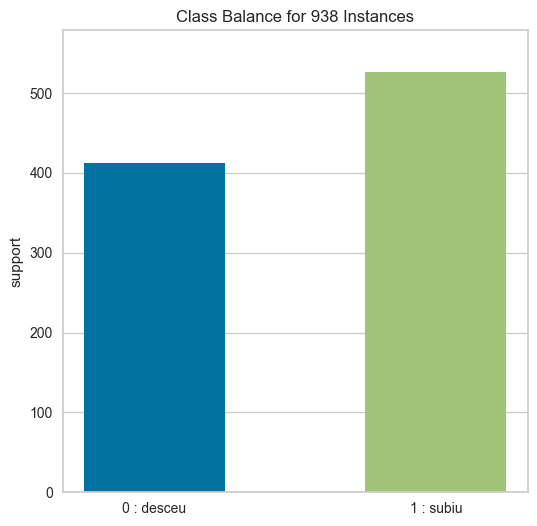

<AxesSubplot:title={'center':'Class Balance for 938 Instances'}, ylabel='support'>

In [234]:
fig, ax = plt.subplots(figsize=(6,6))
cb_viz = ClassBalance(labels=["0 : desceu", "1 : subiu"])
cb_viz.fit(Y)
cb_viz.poof()

In [235]:
# fig, ax =plt.subplots(figsize=(6,6))
# dt_viz = DiscriminationThreshold(rf)
# dt_viz.fit(X,Y)
# dt_viz.poof()

Random forests application

In [236]:

rf.fit(x_train,y_train)
predictrftest = rf.predict(x_test)
print(classification_report(y_test, predictrftest))

              precision    recall  f1-score   support

           0       0.47      0.38      0.42       124
           1       0.58      0.66      0.62       158

    accuracy                           0.54       282
   macro avg       0.52      0.52      0.52       282
weighted avg       0.53      0.54      0.53       282



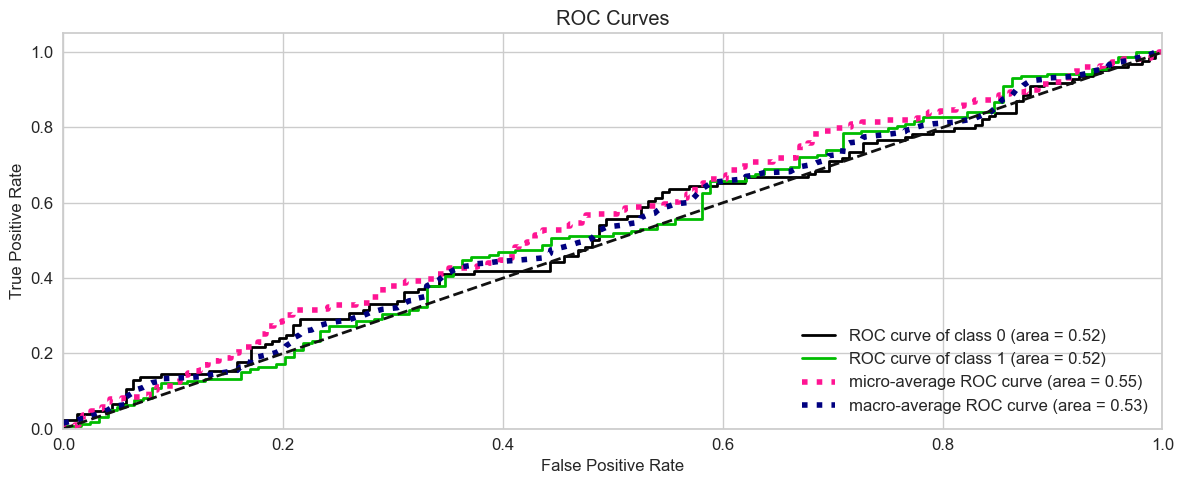

In [237]:
# Prever probabilidades
y_prob = rf.predict_proba(x_test)

# Plotar as curvas ROC 
plot_roc(y_test, y_prob, title='ROC Curves', figsize=(12, 5))


plt.tight_layout()
plt.show()

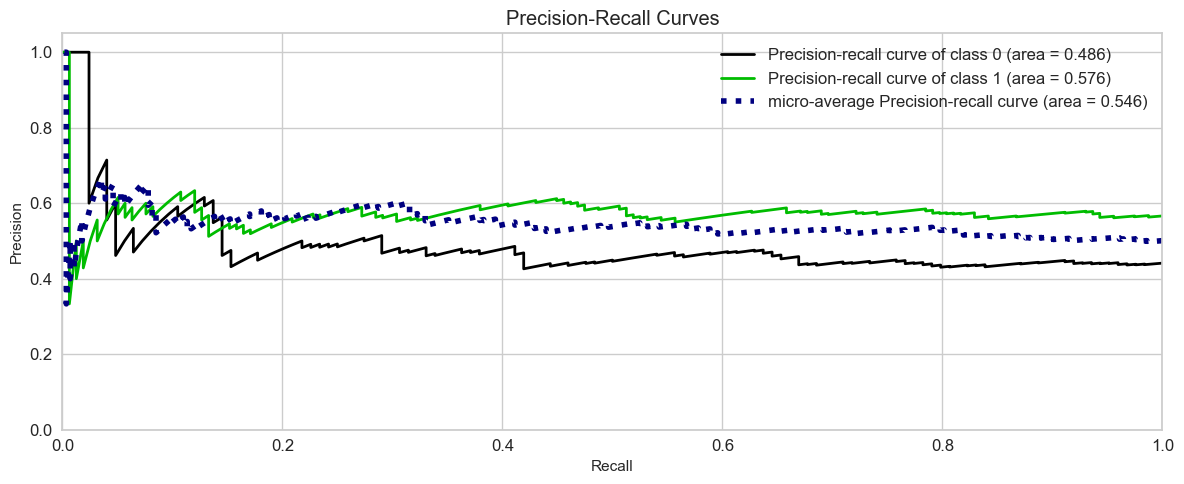

In [238]:
#plotar Precision-Recall
plot_precision_recall(y_test, y_prob, title='Precision-Recall Curves', figsize=(12, 5))

plt.tight_layout()
plt.show()

In [239]:
# explainer = lime_tabular.LimeTabularExplainer(x_train.values, feature_names=X.columns, class_names=["desceu", "subiu"])
# exp = explainer.explain_instance(x_train.iloc[-1].values, rf.predict_proba)
# exp.show_in_notebook()
# exp.as_pyplot_figure()

In [240]:
# model_filename = 'random_forest_model.joblib'
# joblib.dump(rf, model_filename)

In [241]:
# rf = joblib.load('random_forest_model.joblib')


c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


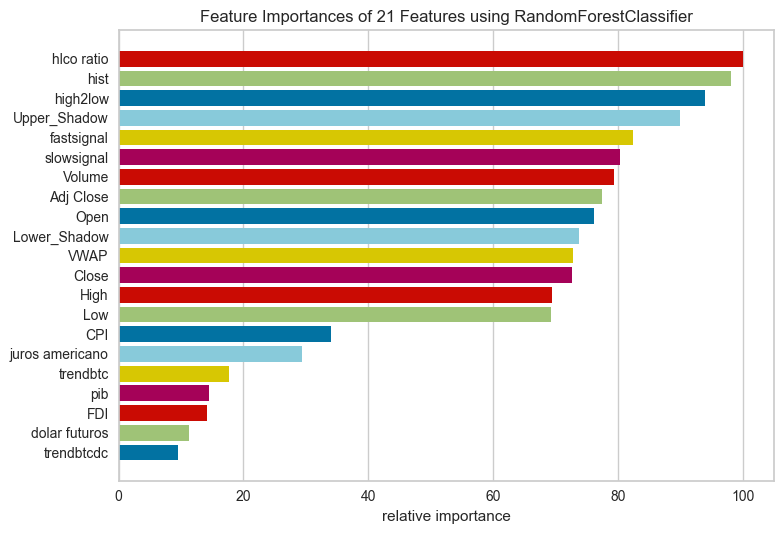

<AxesSubplot:title={'center':'Feature Importances of 21 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [242]:
viz = FeatureImportances(rf)
fig, ax = plt.subplots()
viz = FeatureImportances(rf, relative=True) 
viz.fit(x_train, y_train)
viz.poof()

In [243]:
df_aux = df[df.index >= "2022-01-01"]
dfs_aux = dfs[dfs.index >= '2022-01-01']

In [244]:
K = df_aux["signal"]
Z = df_aux.loc[:, (df_aux.columns != "signal")&(df_aux.columns != "retorno")&(df_aux.columns != "cdi")&(df_aux.columns != "ipca")]

In [245]:
df_aux["sinal modelo"] = custom_model.predict(Z)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [246]:
df_aux["sinal modelo"].value_counts()

0    483
Name: sinal modelo, dtype: int64

In [247]:
rent = list([])
for i in range(len(df_aux)):
    if (df_aux["sinal modelo"].iloc[i-1] == 1):
        rent.append(df_aux["retorno"].iloc[i] - 0.00009)
    elif (df_aux["sinal modelo"].iloc[i-1] == 0):
        rent.append(-df_aux["retorno"].iloc[i]-0.00018 +2*df_aux["cdi"].iloc[i])

In [248]:
df_aux["retorno estrategia"] = rent

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


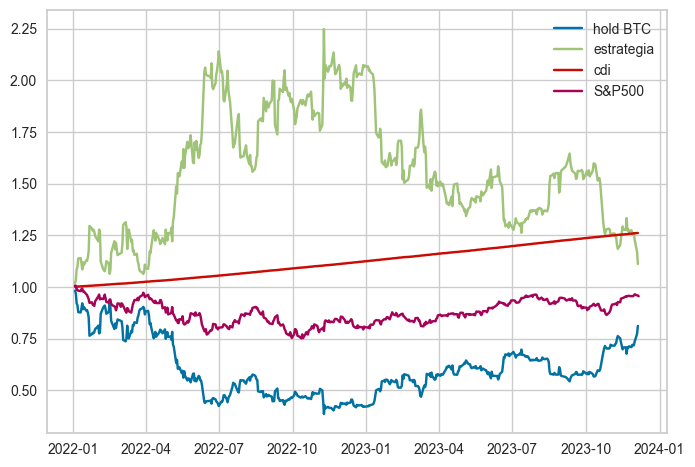

In [249]:
plt.plot(df_aux.index, (df_aux["retorno"]+1).cumprod(), label="hold BTC")
plt.plot(df_aux.index, (df_aux["retorno estrategia"]+1).cumprod(), label="estrategia")
plt.plot(df_aux.index, (df_aux["cdi"]+1).cumprod(), label='cdi')
plt.plot((dfs_aux["retorno"]+1).cumprod(), label='S&P500')
plt.legend()


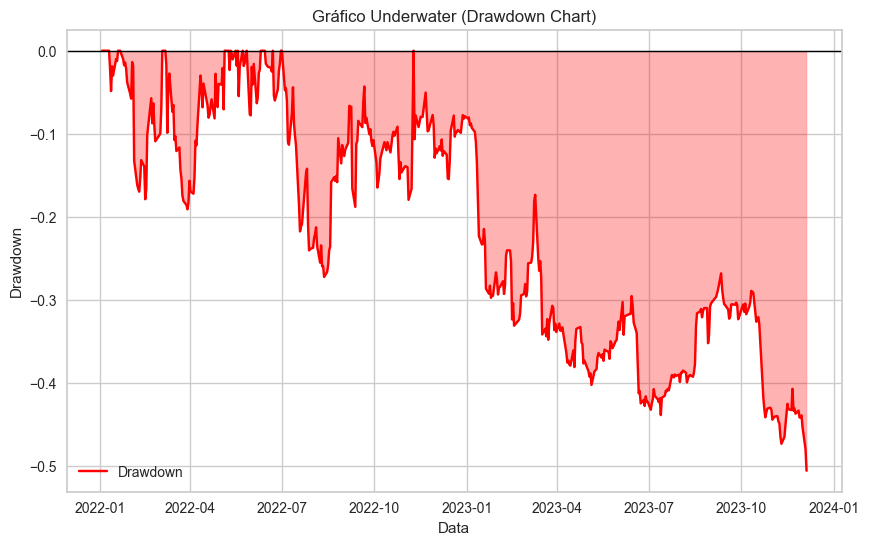

In [250]:
rolling_max = (df_aux['retorno estrategia']+1).cumprod().cummax()
drawdown = ((df_aux['retorno estrategia']+1).cumprod() / rolling_max)  -1

# Plotar o gráfico Underwater
plt.figure(figsize=(10, 6))
plt.plot(df_aux.index, drawdown, color='red', label='Drawdown')
plt.fill_between(df_aux.index, drawdown, color='red', alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.title('Gráfico Underwater (Drawdown Chart)')
plt.legend()
plt.grid(True)
plt.show()

In [251]:
df_aux["excessos retorno"] = df_aux["retorno estrategia"] - df_aux["cdi"]
sharpe_ratio_diario = df_aux["excessos retorno"].mean() / df_aux["excessos retorno"].std()
sharpe_ratio_diario

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.007382472033340248

In [252]:
# Calcular o beta
covariance = np.cov((df_aux['retorno estrategia']-df_aux["cdi"]), (df_aux['retorno'] - df_aux['cdi']))[0][1]
variance_market = np.var(df_aux['retorno']-df_aux['cdi'])

beta = covariance / variance_market

print("Beta da estratégia em relação ao BTC:", beta)

Beta da estratégia em relação ao BTC: -1.0020746887966807


(array([ 1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  4.,  3.,  6.,  7.,
         1.,  3.,  4.,  3.,  7.,  7., 13.,  9., 11., 15., 17., 19., 12.,
        19., 28., 21., 30., 32., 29., 28., 17., 17., 10., 12.,  9., 11.,
         5., 12.,  8.,  3.,  2.,  2.,  4.,  2.,  5.,  1.,  2.,  1.,  4.,
         1.,  1.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.16354706e-01, -1.13586031e-01, -1.10817355e-01, -1.08048680e-01,
        -1.05280004e-01, -1.02511329e-01, -9.97426533e-02, -9.69739779e-02,
        -9.42053024e-02, -9.14366269e-02, -8.86679515e-02, -8.58992760e-02,
        -8.31306005e-02, -8.03619251e-02, -7.75932496e-02, -7.48245741e-02,
        -7.20558987e-02, -6.92872232e-02, -6.65185478e-02, -6.37498723e-02,
        -6.09811968e-02, -5.82125214e-02, -5.54438459e

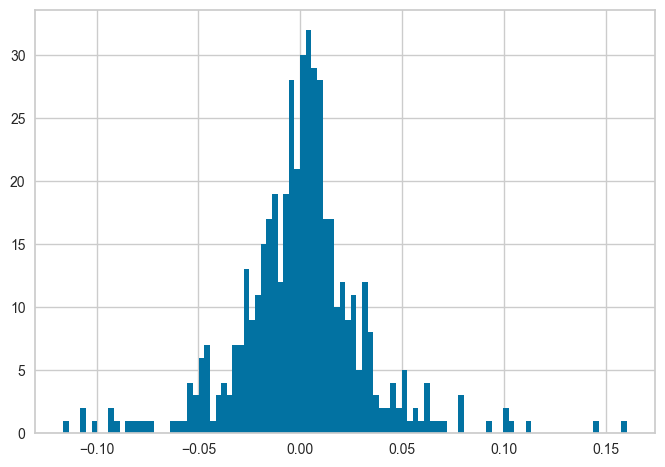

In [253]:
plt.hist(df_aux["retorno estrategia"], bins=100)

In [254]:
bin_edges = np.histogram_bin_edges(df_aux["retorno estrategia"], bins=50)
hist = np.histogram(df_aux["retorno estrategia"])
bin_edges
hist

(array([  7,   6,  33, 129, 224,  58,  16,   7,   1,   2], dtype=int64),
 array([-0.11635471, -0.08866795, -0.0609812 , -0.03329444, -0.00560769,
         0.02207907,  0.04976582,  0.07745258,  0.10513933,  0.13282609,
         0.16051284]))

In [255]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno estrategia"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin a partir do qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à direita do valor de referência
observacoes_direita = sum(hist[indice_bin_referencia:])

print(f"Observações à direita de {valor_referencia}: {observacoes_direita}")

Observações à direita de 0: 197


In [256]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno estrategia"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin até o qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à esquerda do valor de referência
observacoes_esquerda = sum(hist[:indice_bin_referencia])

print(f"Observações à esquerda de {valor_referencia}: {observacoes_esquerda}")


Observações à esquerda de 0: 286


In [257]:
# Separar retornos positivos e negativos
retornos_positivos = df_aux[df_aux['retorno estrategia'] > 0]['retorno estrategia']

retornos_negativos = df_aux[df_aux['retorno estrategia'] < 0]['retorno estrategia']

# Calcular a diferença entre os retornos positivos e negativos
diferenca_retornos = np.sum(retornos_positivos) + np.sum(retornos_negativos)

print(f"Diferença entre retornos positivos e negativos: {diferenca_retornos}")

Diferença entre retornos positivos e negativos: 0.34442749776300197


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  3.,  0.,  0.,  1.,  1.,  1.,  4.,  1.,  2.,  0.,
         6.,  2.,  4.,  2.,  2.,  4.,  6., 12.,  6., 11.,  9., 13.,  9.,
        16., 16., 28., 29., 34., 29., 20., 29., 19., 11., 19., 18., 16.,
        11.,  9., 14.,  6.,  7.,  3.,  3.,  4.,  1.,  7.,  6.,  3.,  4.,
         1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
         2.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.]),
 array([-0.15974726, -0.15698001, -0.15421275, -0.1514455 , -0.14867825,
        -0.14591099, -0.14314374, -0.14037649, -0.13760923, -0.13484198,
        -0.13207473, -0.12930747, -0.12654022, -0.12377297, -0.12100571,
        -0.11823846, -0.11547121, -0.11270395, -0.1099367 , -0.10716945,
        -0.1044022 , -0.10163494, -0.09886769, -0.09610044, -0.09333318,
        -0.09056593, -0.08779868, -0.08503142, -0.08226417, -0.079496

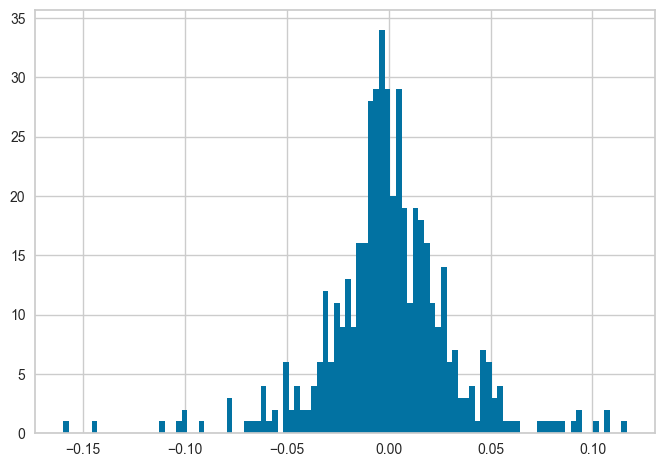

In [258]:
plt.hist(df_aux["retorno"],bins=100)

In [259]:
bin_edges = np.histogram_bin_edges(df_aux["retorno"], bins=50)
hist = np.histogram(df_aux["retorno"])
bin_edges
hist

(array([  2,   1,   7,  16,  58, 223, 130,  33,   6,   7], dtype=int64),
 array([-0.15974726, -0.13207473, -0.1044022 , -0.07672966, -0.04905713,
        -0.0213846 ,  0.00628794,  0.03396047,  0.061633  ,  0.08930553,
         0.11697807]))

In [260]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin a partir do qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à direita do valor de referência
observacoes_direita = sum(hist[indice_bin_referencia:])

print(f"Observações à direita de {valor_referencia}: {observacoes_direita}")


Observações à direita de 0: 225


In [261]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin até o qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à esquerda do valor de referência
observacoes_esquerda = sum(hist[:indice_bin_referencia])

print(f"Observações à esquerda de {valor_referencia}: {observacoes_esquerda}")

Observações à esquerda de 0: 258


In [262]:
# Separar retornos positivos e negativos
retornos_positivos = df_aux[df_aux['retorno'] > 0]['retorno']

retornos_negativos = df_aux[df_aux['retorno'] < 0]['retorno']

# Calcular a diferença entre os retornos positivos e negativos
diferenca_retornos = np.sum(retornos_positivos) + np.sum(retornos_negativos)

print(f"Diferença entre retornos positivos e negativos: {diferenca_retornos}")

Diferença entre retornos positivos e negativos: 0.032424122236999864


In [263]:
# Calcular o alfa
average_return_btc = df_aux['retorno estrategia']
average_return_market = df_aux['retorno']
alpha = np.mean(average_return_btc) - beta * np.mean(average_return_market)

print("Alfa da estratégia em relação ao BTC-USD:", alpha)

Alfa da estratégia em relação ao BTC-USD: 0.0007803703725945087


In [264]:
predict = rf.predict(Z[Z.index > '2022-10-08'])
predict = pd.DataFrame(predict)
predict.index = df_aux[df_aux.index > '2022-10-08'].index
predict.columns = ['sinal']

In [265]:
predict.value_counts()

sinal
0        286
1          3
dtype: int64

In [266]:
rent = list([])
for i in range(len(predict)):
    if (predict['sinal'].iloc[i-1] == 1):
        rent.append(df_aux[df_aux.index > '2022-10-08']["retorno"].iloc[i] - 0.00009)
    elif (predict['sinal'].iloc[i-1] == 0):
        rent.append(-df_aux[df_aux.index > '2022-10-08']["retorno"].iloc[i]-0.00018 +2*df_aux[df_aux.index > '2022-10-08']["cdi"].iloc[i])

In [267]:
retorno_estrategia = np.array(rent)

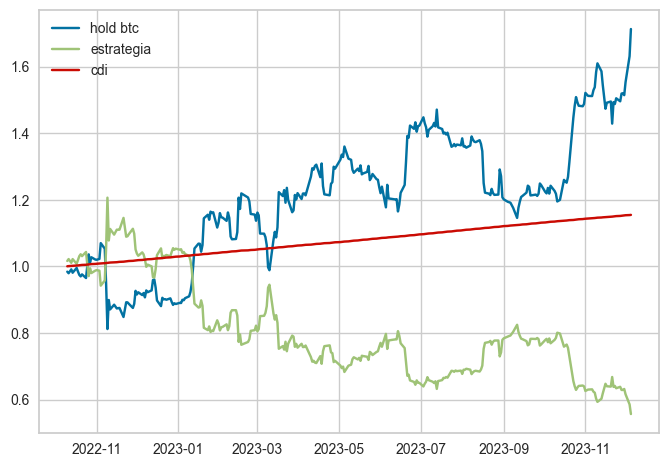

In [268]:
plt.plot(predict.index, (df_aux[df_aux.index > '2022-10-08']["retorno"]+1).cumprod(), label="hold btc")
plt.plot(predict.index, (retorno_estrategia+1).cumprod(), label="estrategia")
plt.plot(predict.index, (df_aux[df_aux.index > '2022-10-08']["cdi"]+1).cumprod(), label='cdi')
#plt.plot(predict.index,(dfs_aux[dfs_aux.index > '2022-10-08']["retorno"]+1).cumprod(), label='S&P500')
plt.legend()

In [269]:
predict = rf.predict(Z[Z.index > '2023-05-01'])
predict = pd.DataFrame(predict)
predict.index = df_aux[df_aux.index > '2023-05-01'].index
predict.columns = ['sinal']

In [270]:
rent = list([])
for i in range(len(predict)):
    if (predict['sinal'].iloc[i-1] == 1):
        rent.append(df_aux[df_aux.index > '2023-05-01']["retorno"].iloc[i] - 0.00009)
    elif (predict['sinal'].iloc[i-1] == 0):
        rent.append(-df_aux[df_aux.index > '2023-05-01']["retorno"].iloc[i]-0.00018 +2*df_aux[df_aux.index > '2023-05-01']["cdi"].iloc[i])

In [271]:
retorno_estrategia = np.array(rent)

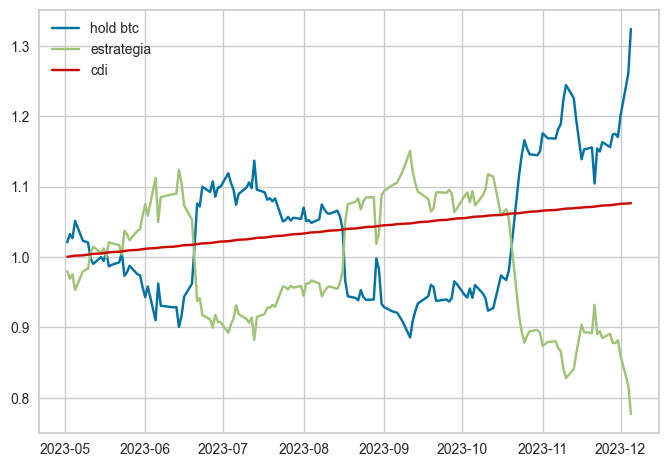

In [272]:
plt.plot(predict.index, (df_aux[df_aux.index > '2023-05-01']["retorno"]+1).cumprod(), label="hold btc")
plt.plot(predict.index, (retorno_estrategia+1).cumprod(), label="estrategia")
plt.plot(predict.index, (df_aux[df_aux.index > '2023-05-01']["cdi"]+1).cumprod(), label='cdi')
# plt.plot(predict.index,(dfs_aux[dfs_aux.index > '2022-10-08']["retorno"]+1).cumprod(), label='S&P500')
plt.legend()

In [273]:
# Y = pd.DataFrame(Y)
# Y

In [274]:
# tree_accuracies = []
# for tree in rf.estimators_:
#     y_pred = tree.predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     tree_accuracies.append(accuracy)

# # Identificar a árvore de maior precisão
# best_tree_index = tree_accuracies.index(max(tree_accuracies))
# best_tree = rf.estimators_[best_tree_index]

# # Exportar a árvore para visualização
# dot_data = export_graphviz(best_tree, out_file=None,
#                            feature_names=X.columns,
#                            class_names=['Classe 0', 'Classe 1'],
#                            filled=True, rounded=True,
#                            special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render('best_tree', format='png')  # Isso salvará a árvore em um arquivo
# graph.view()

In [275]:
M = df[df.index > "2017-01-01"]["signal"]
J = df[df.index > "2017-01-01"].loc[:, (df.columns != "signal")&(df.columns != "retorno")&(df.columns != "cdi")&(df.columns != "ipca")]

J = pd.DataFrame(J)
M = M.astype('int')
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)


In [276]:

predictrftest = rf.predict(J)
print(classification_report(M, predictrftest))

              precision    recall  f1-score   support

           0       0.54      0.91      0.68       817
           1       0.79      0.31      0.45       920

    accuracy                           0.59      1737
   macro avg       0.66      0.61      0.56      1737
weighted avg       0.67      0.59      0.56      1737



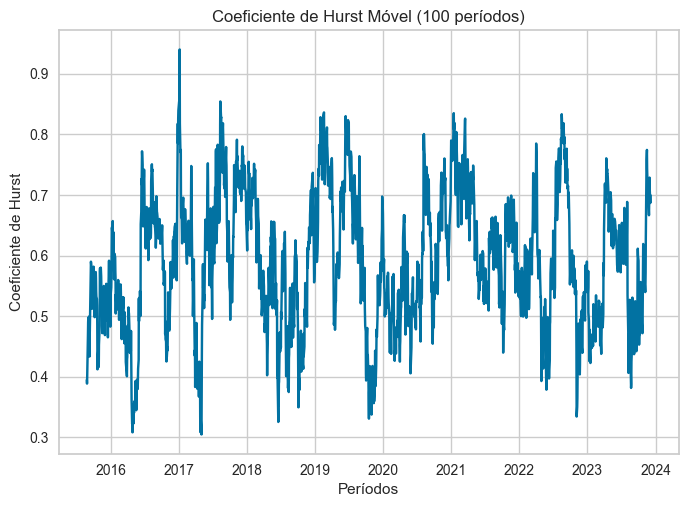

In [277]:
def calculate_hurst(data, window_size):
    hurst_values = []

    for i in range(window_size, len(data)):
        # subset = data[i - window_size:i]
        # lag_values = np.subtract(subset, subset.shift(1)).dropna()
        # dev = np.std(lag_values)
        s = df['Close'][i - window_size:i]
        H, c, val = compute_Hc(s)
        hurst = H
        hurst_values.append(hurst)

    return hurst_values

window_size = 100
hurst_values = calculate_hurst(df["Close"], window_size)

plt.plot(df.index[100:], hurst_values)
plt.title(f"Coeficiente de Hurst Móvel ({window_size} períodos)")
plt.xlabel("Períodos")
plt.ylabel("Coeficiente de Hurst")
plt.show()

In [278]:
hv = pd.DataFrame(hurst_values)

In [279]:
hv.index = df.index[100:]
hv.columns = ["HV"]

In [280]:
df1 = df[df.index > "2019-01-01"]



In [281]:
df1["sinal parametro"] = dfte["sinal"]
df1["HV"] = hv["HV"]

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [282]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1238 entries, 2019-01-02 to 2023-12-05
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1238 non-null   float64
 1   High             1238 non-null   float64
 2   Low              1238 non-null   float64
 3   Close            1238 non-null   float64
 4   Adj Close        1238 non-null   float64
 5   Volume           1238 non-null   int64  
 6   dolar futuros    1238 non-null   object 
 7   juros americano  1238 non-null   float64
 8   trendbtc         1238 non-null   float64
 9   trendbtcdc       1238 non-null   float64
 10  fastsignal       1238 non-null   float64
 11  slowsignal       1238 non-null   float64
 12  hist             1238 non-null   float64
 13  FDI              1238 non-null   float64
 14  CPI              1238 non-null   float64
 15  pib              1238 non-null   float64
 16  retorno          1238 non-null   float64
 

In [283]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1238 entries, 2019-01-02 to 2023-12-05
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1238 non-null   float64
 1   High             1238 non-null   float64
 2   Low              1238 non-null   float64
 3   Close            1238 non-null   float64
 4   Adj Close        1238 non-null   float64
 5   Volume           1238 non-null   int64  
 6   dolar futuros    1238 non-null   object 
 7   juros americano  1238 non-null   float64
 8   trendbtc         1238 non-null   float64
 9   trendbtcdc       1238 non-null   float64
 10  fastsignal       1238 non-null   float64
 11  slowsignal       1238 non-null   float64
 12  hist             1238 non-null   float64
 13  FDI              1238 non-null   float64
 14  CPI              1238 non-null   float64
 15  pib              1238 non-null   float64
 16  retorno          1238 non-null   float64
 

In [284]:
df1["sinal parametro"] = df1["sinal parametro"].fillna(2)
for i in range(len(df1)-1):
    if (df1["sinal parametro"].iloc[i] == 2):
        df1["sinal parametro"].iloc[i] = df1["sinal parametro"].iloc[i+1]

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [285]:
sinal = []
for i in range(len(df1)):
   
   
    if (df1["sinal parametro"].iloc[i] == 0):#&(df1["HV"].iloc[i] > 0.7):
         custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.30)
         if 'custom_model' in locals():
             par = custom_model.predict(J.iloc[i].values.reshape(1, -1))
             sinal.append(par)
         
    # elif (df1["sinal parametro"].iloc[i] == 0)&(df1["HV"].iloc[i] < 0.3):
    #      custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.40)
    #      if 'custom_model' in locals():
    #          par = custom_model.predict(J.iloc[i].values.reshape(1, -1))
    #          sinal.append(par)
    
    # elif (df1["sinal parametro"].iloc[i] == 0)&(df1["HV"].iloc[i] > 0.3)&(df1["HV"].iloc[i] < 0.7):
    #      custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.45)
    #      if 'custom_model' in locals():
    #          par = custom_model.predict(J.iloc[i].values.reshape(1, -1))
    #          sinal.append(par)
    
    # elif (df1["sinal parametro"].iloc[i] == 1)&(df1["HV"].iloc[i] > 0.3)&(df1["HV"].iloc[i] < 0.7):
    #      custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.55)
    #      if 'custom_model' in locals():
    #          par = custom_model.predict(J.iloc[i].values.reshape(1, -1))
    #          sinal.append(par)
        
    # elif (df1["sinal parametro"].iloc[i] == 1)&(df1["HV"].iloc[i] > 0.7):
    #      custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.80)
    #      if 'custom_model' in locals():
    #          par = custom_model.predict(J.iloc[i].values.reshape(1, -1))
    #          sinal.append(par)
         
    elif (df1["sinal parametro"].iloc[i] == 1):#&(df1["HV"].iloc[i] < 0.3):
         custom_model = CustomThresholdClassifier(base_classifier=rf, threshold=0.70)
         if 'custom_model' in locals():
             par = custom_model.predict(J.iloc[i].values.reshape(1, -1))
             sinal.append(par)
    elif (i == len(df1)-1):
        print(1)
        sinal.append(0)
         ###pegar os intermediários de hv e entender se o coeficiente esta aumentando ou diminuindo, caso esteja aumentando, beneficiar o sinal do parametro do treasurie, se estiver diminuindo, beneficiar o contrario do parametro mencionado anteriormente

c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid featu

In [286]:
df1["sinal modelo"] = sinal

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
# pd.Series(df1["sinal modelo"]).value_counts()

In [288]:
rent = list([])
for i in range(len(df1)):
    if (df1["sinal modelo"].iloc[i-1] == 1):
        rent.append(df1["retorno"].iloc[i] - 0.00009)
    elif (df1["sinal modelo"].iloc[i-1] == 0):
        rent.append(-df1["retorno"].iloc[i]-0.00018 +2*df1["cdi"].iloc[i])

In [289]:
df1['retorno modelo + fatores'] = rent

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


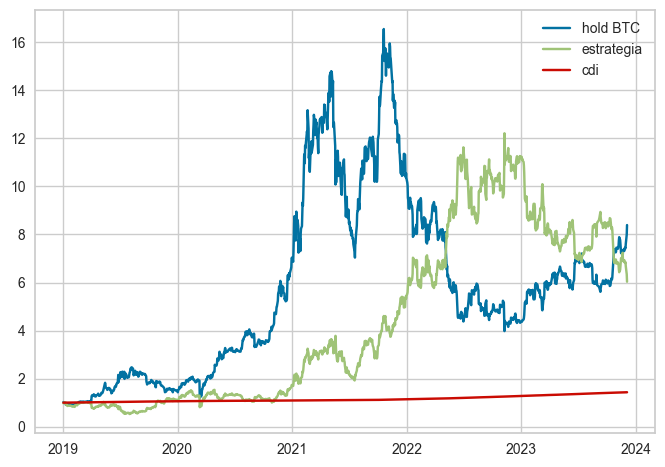

In [290]:
plt.plot(df1.index, (df1["retorno"]+1).cumprod(), label="hold BTC")
plt.plot(df1.index, (df1["retorno modelo + fatores"]+1).cumprod(), label="estrategia")
plt.plot(df1.index, (df1["cdi"]+1).cumprod(), label='cdi')
plt.legend()
